In [1]:
from gumbel_sigmoid_softmax import gumbel_sigmoid
import torch
import numpy as np

### Simple demo
* Sample from gumbel-softmax
* Average over samples

In [2]:
temperature = 0.1
logits = np.linspace(-5, 5, 10).reshape([1,-1])
logits = torch.Tensor(logits)
gumbel_sigm = gumbel_sigmoid(logits, temperature=temperature)
sigm = torch.sigmoid(logits)

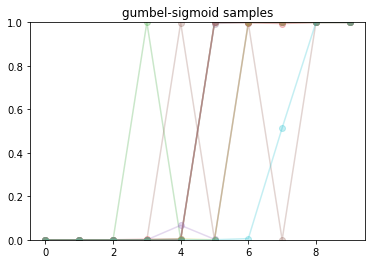

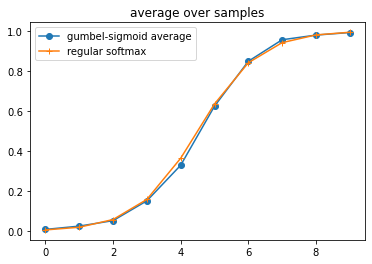

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('gumbel-sigmoid samples')
for i in range(10):
    plt.plot(range(10), gumbel_sigmoid(logits, temperature=temperature)[0], marker='o', alpha=0.25)
plt.ylim(0,1)
plt.show()

plt.title('average over samples')
samples = torch.stack(
    [gumbel_sigmoid(logits, temperature=temperature)[0] for _ in range(500)],
    dim=0
)
# samples
plt.plot(range(10), torch.mean(samples, axis=0),
         marker='o', label='gumbel-sigmoid average')

plt.plot(sigm[0], marker='+',label='regular softmax')
plt.legend(loc='best')

# Autoencoder with gumbel-sigmoid

* We do not use any bayesian regularization, simply optimizer by backprop
* Hidden layer contains 32 units

In [4]:
from sklearn.datasets import load_digits
X = load_digits().data
print(X.shape)

(1797, 64)


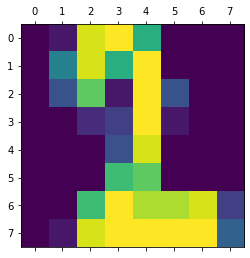

In [5]:
plt.matshow(X[1111].reshape(8,8))

In [6]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
import torch
from torch import nn


class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 32)  # #bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 64)
        )
        self.tau = 1.0

    def set_temperature(self, tau):
        self.tau = tau
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

    def reparameterization(self, x, hard=False):
        return gumbel_sigmoid(x, temperature=self.tau, hard=hard)

    def forward(self, x, hard=False):
        x = self.encode(x)
        x = self.reparameterization(x, hard=hard)
        x = self.decode(x)
        return x

model = EncoderDecoder().to(device)
print(model)

EncoderDecoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
  )
)


## Training loop
* We gradually reduce temperature from 1 to 0.01 over time

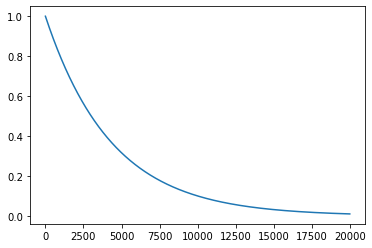

In [8]:
tau_values = np.logspace(0,-2,20000)
tau_values = np.clip(tau_values, 0.01, None)
plt.plot(tau_values)

In [9]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

for i, t in enumerate(tau_values):
    batch = X[np.random.choice(len(X),32)]
    batch = torch.Tensor(batch).to(device)
    model.set_temperature(t)
    output = model(batch)
    loss = criteria(batch, output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        with torch.no_grad():
            batch = X[np.random.choice(len(X), 320)]
            batch = torch.Tensor(batch).to(device)
            output = model(batch)
            loss = criteria(batch, output)
            print('%.3f' % loss, end='\t', flush=True)

59.389	21.970	18.809	18.953	18.936	18.500	18.749	18.604	18.801	18.861	18.600	18.898	19.062	18.904	18.675	18.496	18.862	18.863	18.659	19.072	18.662	18.982	18.596	18.540	19.188	19.118	18.827	18.596	18.427	18.065	17.933	16.729	16.633	16.096	15.722	15.771	15.956	15.523	15.299	14.639	15.365	15.102	14.741	14.486	14.737	14.730	14.316	14.203	14.447	13.920	13.928	13.925	13.337	13.093	13.011	12.726	13.099	12.900	12.538	12.094	12.826	12.141	12.396	12.388	11.647	11.760	11.509	11.708	11.197	11.160	11.295	10.966	10.779	10.848	10.786	10.753	10.563	10.899	10.742	10.687	10.621	10.247	10.590	10.493	9.912	10.233	10.263	10.542	9.913	9.830	10.080	9.823	9.782	9.722	9.793	9.671	9.697	9.115	9.274	9.254	9.349	9.407	9.792	9.379	9.066	9.182	9.086	9.173	8.962	8.954	9.246	9.035	8.929	8.892	8.699	8.890	8.720	9.057	8.340	8.772	8.898	8.874	8.700	8.735	8.616	8.229	8.586	8.623	8.595	8.688	8.475	8.803	8.437	8.250	8.287	8.558	8.584	8.003	8.358	8.272	8.138	8.670	8.508	8.536	8.565	8.095	8.343	8.616	8.545	8.435	8.436	8.067	

In [10]:
#functions for visualization
get_sample = lambda x : model(x.to(device)).detach().cpu().numpy()
get_sample_hard = lambda x : model(x.to(device), hard=True).detach().cpu().numpy()
get_code = lambda x : model.reparameterization(model.encode(x.to(device))).detach().cpu().numpy()


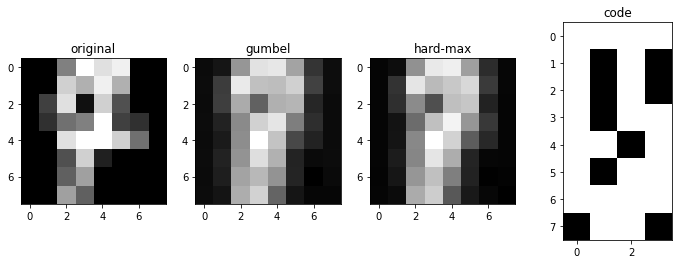

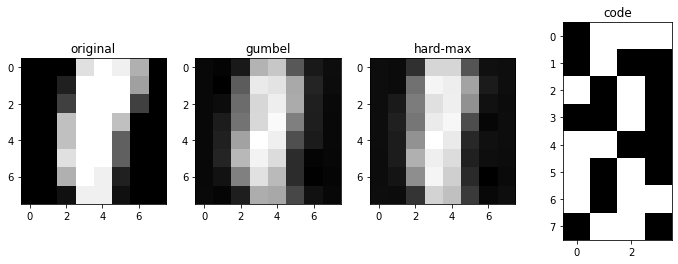

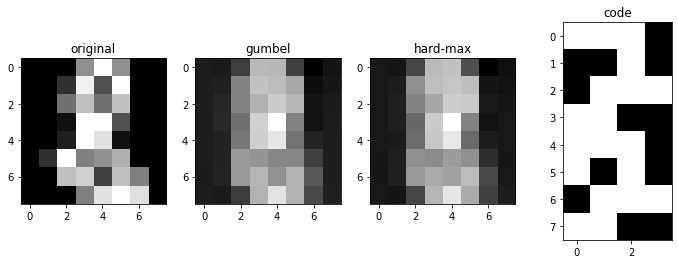

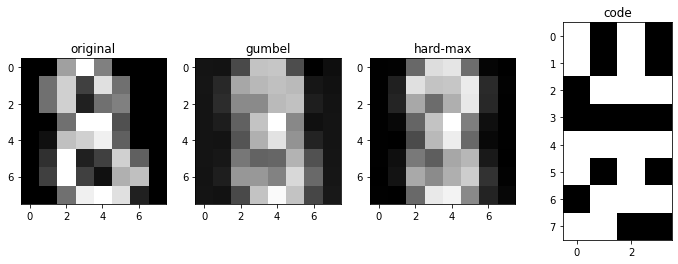

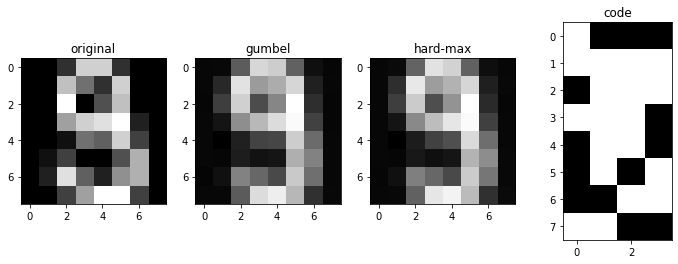

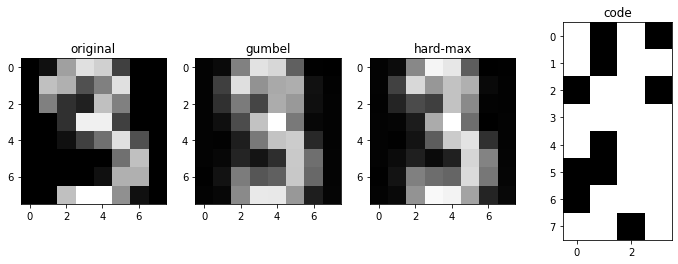

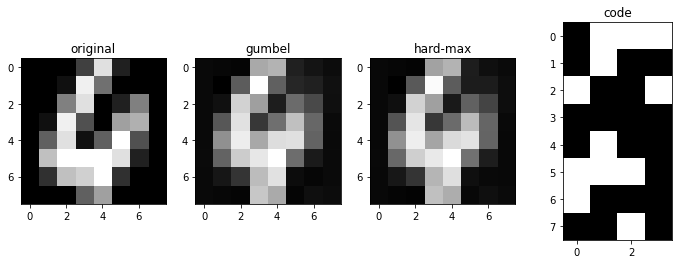

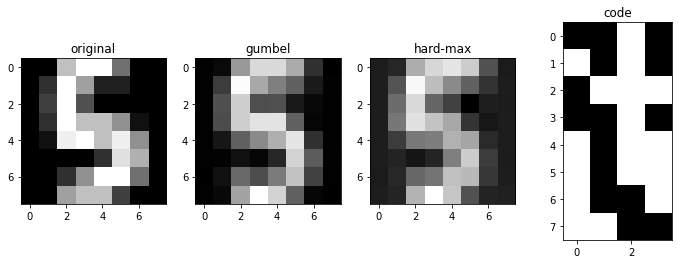

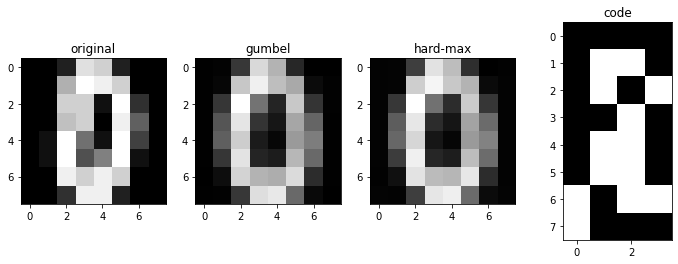

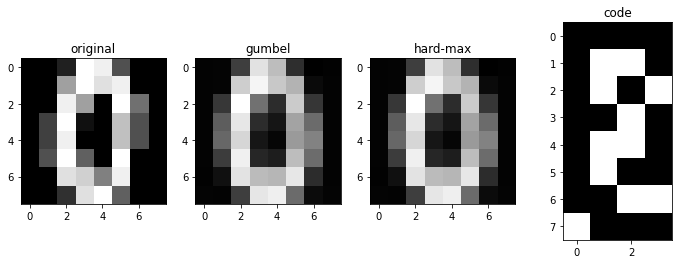

In [11]:
for i in range(10):
    X_sample = X[np.random.randint(len(X)),None,:]
    X_sample = torch.Tensor(X_sample).unsqueeze(0)
    plt.figure(figsize=[12,4])
    plt.subplot(1,4,1)
    plt.title("original")
    plt.imshow(X_sample.reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,2)
    plt.title("gumbel")
    plt.imshow(get_sample(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,3)
    plt.title("hard-max")
    plt.imshow(get_sample_hard(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,4)
    plt.title("code")
    plt.imshow(get_code(X_sample).reshape(8,4),interpolation='none',cmap='gray')
    plt.show()